In [1]:
import tensorflow as tf
import numpy as np
import random
import time

from game import Game
from model import DQN


tf.app.flags.DEFINE_boolean("train", False, "학습모드. 게임을 화면에 보여주지 않습니다.")
FLAGS = tf.app.flags.FLAGS
MAX_EPISODE = 10000
TARGET_UPDATE_INTERVAL = 1000
TRAIN_INTERVAL = 4
OBSERVE = 100
NUM_ACTION = 3
SCREEN_WIDTH = 6
SCREEN_HEIGHT = 10

NUM_ACTION = 3
SCREEN_WIDTH = 6
SCREEN_HEIGHT = 10



/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


뇌세포 깨우는 중..


NameError: name 'exit' is not defined

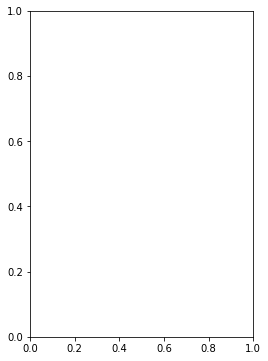

In [2]:
def train():
    print('뇌세포 깨우는 중..')
    sess = tf.Session()
    
    game = Game(SCREEN_WIDTH, SCREEN_HEIGHT, show_game=False)
    brain = DQN(sess, SCREEN_WIDTH, SCREEN_HEIGHT, NUM_ACTION)
    rewards = tf.placeholder(tf.float32, [None])
    tf.summary.scalar('avg.reward/ep.', tf.reduce_mean(rewards))
    
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    
    writer = tf.summary.FileWriter('logs', sess.graph)
    summary_merged = tf.summary.merge_all()
    
    brain.update_target_network()
    epsilon = 1.0
    
    time_step = 0
    total_reward_list = []
    
    for episode in range(MAX_EPISODE):
        terminal = False
        total_reward = 0
        
        state = game.reset()
        brain.init_state(state)
        
        while not terminal:
            if np.random.rand() < epsilon:
                action = random.randrange(NUM_ACTION)
            else:
                action = brain.get_action()
                
            if episode > OBSERVE:
                epsilon -= 1/1000
                
            state, reward, terminal = game.step(action)
            total_reward += reward
            
            brain.remember(state, action, reward, terminal)
            
            if time_step > OBSERVE and time_step % TRAIN_INTERVAL == 0:
                brain.train()
                
            if time_step % TARGET_UPDATE_INTERVAL == 0:
                brain.update_target_network()
                
            time_step += 1
            
        print('게임횟수: %d 점수: %d' % (episode + 1, total_reward))
        
        total_reward_list.append(total_reward)
        
        if episode % 10 == 0:
            summary = sess.run(summary_merged, feed_dict={rewards: total_reward_list})
            writer.add_summary(summary, time_step)
            total_reward_list = []
            
        if episode % 100 == 0:
            saver.save(sess, 'model/dqn.ckpt', global_step=time_step)
            
def replay():
    print('뇌세포 깨우는 중..')
    sess = tf.Session()
    
    game = Game(SCREEN_WIDTH, SCREEN_HEIGHT, show_game=True)
    brain = DQN(sess, SCREEN_WIDTH, SCREEN_HEIGHT, NUM_ACTION)
    
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state('model')
    saver.restore(sess, ckpt.model_checkpoint_path)
    
    for episode in range(MAX_EPISODE):
        terminal = False
        total_reward = 0
        
        state = game.reset()
        brain.init_state(state)
        
        while not terminal:
            action = brain.get_action()
            
            state, reward, terminal = game.step(action)
            total_reward += reward
            
            brain.remember(state, action, reward, terminal)
            
            time.sleep(0.3)
            
        print('게임횟수: %d 점수: %d' % (episode + 1, total_reward))
        
        
def main(_):
    if FLAGS.train:
        train()
    else:
        replay()
        

if __name__ == '__main__':
    tf.app.run()